<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./06_bayesian_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 6: Bayesian Linear Regression & Classification

Probabilistic Machine Learning -- Spring 2025, UniTS


In this notebook, we explore linear regression and classification from a Bayesian point of view. In both cases, we start implementing the classical formulation and then we switch to the Bayesian version. We can then compare the methods on a simple example.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

The first model that we implement is the well known linear regression model and we use the "linear algebra view" that we studied during the lessons.

As a case study, we use the [Kaggle dataset](https://www.kaggle.com/datasets/budincsevity/szeged-weather/data) about Weather in Szeged (Hungary) between 2006 and 2016 and we try to predict the apparent temperature given some predictors.



In [12]:
weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
weatherHistory

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [13]:
weatherHistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [14]:
#Let's reduce the size of the dataset by considering one row for each day (corresponding to 16:00), only in 2015
#Training: April, Test: May
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)
data.info()
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            30 non-null     datetime64[ns, UTC]
 1   Summary                   30 non-null     object             
 2   Precip Type               30 non-null     object             
 3   Temperature (C)           30 non-null     float64            
 4   Apparent Temperature (C)  30 non-null     float64            
 5   Humidity                  30 non-null     float64            
 6   Wind Speed (km/h)         30 non-null     float64            
 7   Wind Bearing (degrees)    30 non-null     float64            
 8   Visibility (km)           30 non-null     float64            
 9   Loud Cover                30 non-null     float64            
 10  Pressure (millibars)      30 non-null     float64            
 11  Daily Summary        

Text(0.5, 1.0, 'Humidity vs Apparent Temperature ')

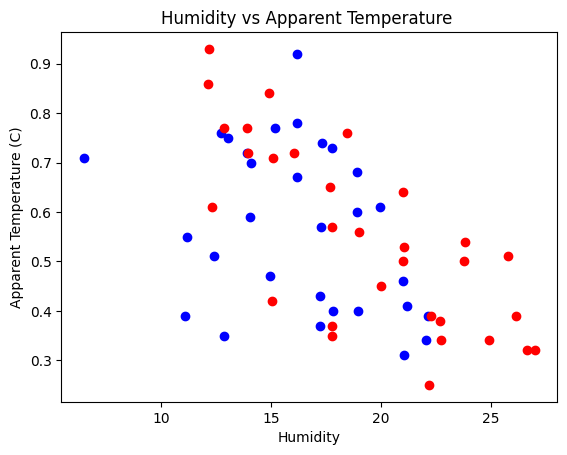

In [15]:
plt.scatter(data["Apparent Temperature (C)"], data["Humidity"], label = "train", color='blue')
plt.scatter(data_test["Apparent Temperature (C)"], data_test["Humidity"], label = "test", color='red')

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature ")

In order to perform the linear regression, we follow the maximum likelihood approach:
$$\theta_{ML} = \text{argmax } p(\underline{y} | \underline{x}, \theta)$$

and we define our parametric model as:
$$p(y|x, \theta) = \mathcal{N}(y|f(x,w), \beta^{-1})$$

where 

$$f(x,w) = w_0 \phi_0(x) + \ldots + w_{M-1}\phi_{M-1}(x)$$

with $\phi$ basis functions.

The weighs can be computed by:

$$w_M = \left( \Phi^T \Phi \right)^{-1} \Phi^T \underline{y}$$

where $\Phi$ is the design matrix.

In [16]:
def linear_basis(x):
    return x

def linear_regression(x,y,basis_function):
    N = len(y)
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N, 1)), train_features))
    print("PHI", PHI)
    A = np.linalg.inv(PHI.T@PHI)
    D = A@PHI.T
    w = D@y
    return np.dot(PHI, w), w
    

def predict_linear_regression(x,N,w,basis_function):
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N, 1)), train_features))
    return np.dot(PHI, w)

We can perform the linear regression on the dataset and compute:

- Mean Squared Error (MSE): $$\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2$$
- Log Likelihood: $$\sum_i -\frac{1}{2} \log(2\pi\sigma_i^2) - \frac{(y_i - \mu_i)^2}{2\sigma_i^2}$$


10.0
PHI [[1.   0.43]
 [1.   0.71]
 [1.   0.51]
 [1.   0.47]
 [1.   0.37]
 [1.   0.75]
 [1.   0.39]
 [1.   0.55]
 [1.   0.76]
 [1.   0.67]
 [1.   0.7 ]
 [1.   0.4 ]
 [1.   0.72]
 [1.   0.46]
 [1.   0.68]
 [1.   0.61]
 [1.   0.92]
 [1.   0.78]
 [1.   0.6 ]
 [1.   0.31]
 [1.   0.39]
 [1.   0.74]
 [1.   0.4 ]
 [1.   0.73]
 [1.   0.34]
 [1.   0.77]
 [1.   0.59]
 [1.   0.57]
 [1.   0.41]
 [1.   0.35]]


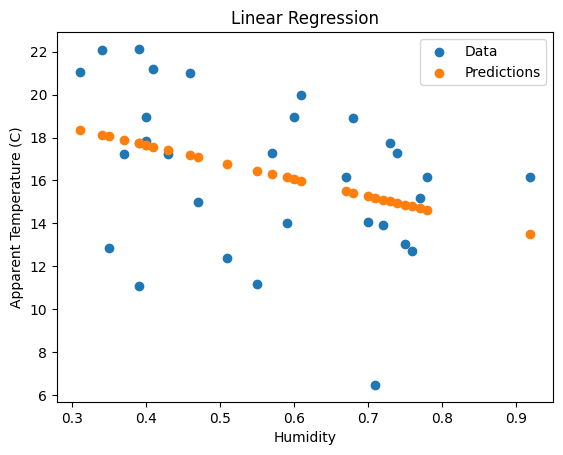

MSE:
15.003278972671396
Log Likelihood:
-164.16046416298286


In [17]:
#in this case x and y are row vectors, so we need to convert them to column vectors
x = data["Humidity"].to_numpy().reshape(-1,1)
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

beta = 0.01
print(np.sqrt(1/beta))

y_pred_linear, w = linear_regression(x,y,linear_basis)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data["Humidity"].to_numpy(), y_pred_linear, label = 'Predictions')

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_pred_linear.T-y)**2))
print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred_linear.T-y)**2))

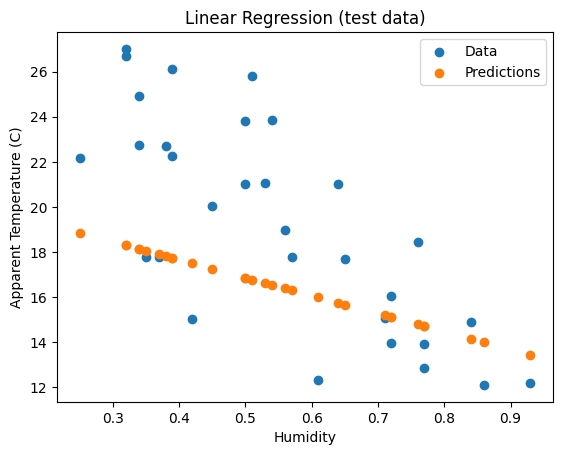

MSE:
31.098261165291554
Log Likelihood:
-249.29437731138614


In [18]:
#Let's see now on the test set

x_test = data_test["Humidity"].to_numpy().reshape(-1,1)
y_test = data_test["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

y_test_pred= predict_linear_regression(x_test,len(x_test),w,linear_basis)

plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data_test["Humidity"].to_numpy(), y_test_pred, label = 'Predictions')

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression (test data)")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_test_pred.T-y_test)**2))
print("Log Likelihood:")
print(-len(y_test)/2*np.log(2*np.pi*1/beta) - 1/2*np.sum((y_test_pred.T-y_test)**2*beta))


PHI [[1.     0.1849]
 [1.     0.5041]
 [1.     0.2601]
 [1.     0.2209]
 [1.     0.1369]
 [1.     0.5625]
 [1.     0.1521]
 [1.     0.3025]
 [1.     0.5776]
 [1.     0.4489]
 [1.     0.49  ]
 [1.     0.16  ]
 [1.     0.5184]
 [1.     0.2116]
 [1.     0.4624]
 [1.     0.3721]
 [1.     0.8464]
 [1.     0.6084]
 [1.     0.36  ]
 [1.     0.0961]
 [1.     0.1521]
 [1.     0.5476]
 [1.     0.16  ]
 [1.     0.5329]
 [1.     0.1156]
 [1.     0.5929]
 [1.     0.3481]
 [1.     0.3249]
 [1.     0.1681]
 [1.     0.1225]]


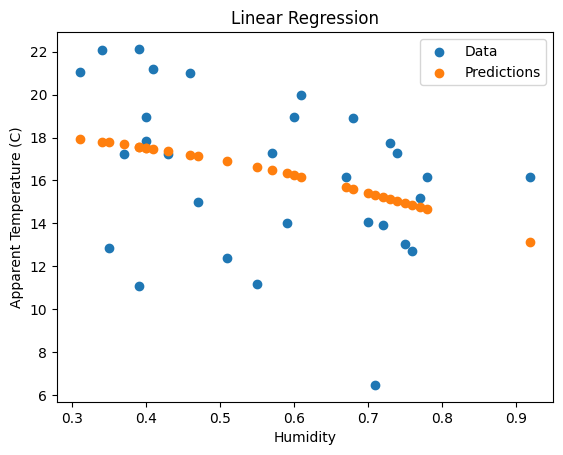

MSE:
14.787126158353798
Log Likelihood:
-163.18777649855366


In [19]:
#Let's try to change the basis function

def square_basis(x):
    return  x**2

y_pred, w = linear_regression(x,y,square_basis)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data["Humidity"].to_numpy(), y_pred, label = 'Predictions')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_pred.T-y)**2))
print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred.T-y)**2))

In [20]:
#We can also consider more predictors

x = data[["Temperature (C)", "Humidity", "Wind Speed (km/h)"]].to_numpy()
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

In [21]:
y_pred, w = linear_regression(x,y,linear_basis)

print("Weights:")
print(w)


PHI [[ 1.         17.23888889  0.43        5.2969    ]
 [ 1.          8.86111111  0.71       15.4238    ]
 [ 1.         12.40555556  0.51       12.1072    ]
 [ 1.         14.97222222  0.47       12.1877    ]
 [ 1.         17.24444444  0.37        2.415     ]
 [ 1.         13.01666667  0.75       20.0928    ]
 [ 1.         11.06111111  0.39       20.9783    ]
 [ 1.         11.16111111  0.55       20.9461    ]
 [ 1.         12.71666667  0.76        6.9874    ]
 [ 1.         16.18333333  0.67        9.1448    ]
 [ 1.         14.07222222  0.7         3.5742    ]
 [ 1.         17.82222222  0.4        10.8675    ]
 [ 1.         13.91111111  0.72        9.2092    ]
 [ 1.         20.99444444  0.46       15.5043    ]
 [ 1.         18.92777778  0.68        4.6529    ]
 [ 1.         19.97777778  0.61        3.0751    ]
 [ 1.         16.18333333  0.92       10.626     ]
 [ 1.         16.17777778  0.78       10.5294    ]
 [ 1.         18.93333333  0.6        12.6224    ]
 [ 1.         21.06111111  

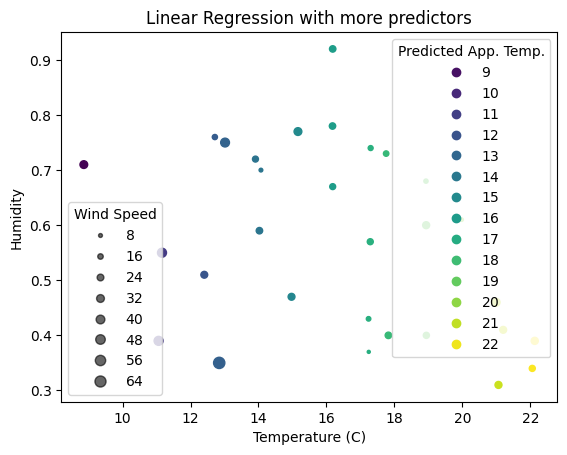

In [22]:
fig, ax = plt.subplots()
scatter = ax.scatter(data["Temperature (C)"], data["Humidity"], s = data["Wind Speed (km/h)"]*2, c = y_pred)
legend1 = ax.legend(*scatter.legend_elements(), loc = 'upper right', title="Predicted App. Temp.")
ax.add_artist(legend1)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc = 'lower left', title="Wind Speed")

plt.title("Linear Regression with more predictors")
plt.ylabel("Humidity")
plt.xlabel("Temperature (C)")
plt.show()

In [23]:
print("MSE:")
print(np.mean((y_pred.T-y)**2))

print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred.T-y)**2))

MSE:
26.40820279470182
Log Likelihood:
-215.48262136211974


## Bayesian Linear Regression

We now consider a prior distribution on the weights, which in this case is:

$$p(w|\alpha) = \mathcal{N}(w| 0, \alpha^{-1} I)$$

So, we can use Bayes theorem to compute the posterior:

$$    p(w| \underline{x}, \underline{y}, \alpha, \beta) = \frac{p(\underline{y}| \underline{x}, w, \beta) p(w|\alpha)}{p(\underline{y}| \underline{x}, \alpha, \beta)}$$

and notice that it is a Gaussian distribution:

$$p(w|\underline{x}, \underline{y}, \alpha, \beta) = \mathcal{N} (w | m_N, S_N)$$

where 

$$m_N = \beta S_N \Phi^T \underline{y}$$
$$S_N^{-1} = \alpha I + \beta \Phi^T \Phi$$

Once we have the posterior distribution, we can calculate the predictive distribution as:

$$p(y|x, \underline{x} , \underline{y}, \alpha, \beta)  = \mathcal{N} \left(y| m_N^T \phi(x), \sigma_N^2(x) \right)$$

where 

$$\sigma_N^2(x) = \frac{1}{\beta} + \phi^T(x) S_N \phi(x)$$

For simplicity and for visualizing the result, we test on a single predictor.

In [24]:
#Bayesian Regression with alpha and beta fixed and a gaussian prior

def bayesian_linear_regression(x,y,basis_function, alpha, beta):
    N = len(y)
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N,1)), train_features))
    SN = np.linalg.inv(alpha*np.eye(PHI.shape[1]) + beta*PHI.T@PHI)
    mN = beta*SN@PHI.T@y
    return np.dot(mN.T, PHI.T), np.sqrt(1/beta+np.diag(PHI@SN@PHI.T)), mN, SN

def predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta):
    train_features = basis_function(x)
    PHI = np.hstack((np.ones((N,1)), train_features))
    return np.dot(mN.T, PHI.T)[0], np.sqrt(1/beta+np.diag(PHI@SN@PHI.T))

def plot_bayesian_LR(mN, SN, N, x, basis_function, beta):
    mean, sigma = predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta)
    plt.plot(x.T[0],mean)
    plt.fill_between(x.T[0], mean-sigma, mean+sigma, alpha=0.2)


In [25]:
x = data["Humidity"].to_numpy().reshape(-1,1)
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

x_test = data_test["Humidity"].to_numpy().reshape(-1,1)
y_test = data_test["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

alpha = 0.002

In [26]:
y_pred_bayes, sigma_pred, mN, SN = bayesian_linear_regression(x,y,linear_basis, alpha, beta)
print(f' y_pred_bayes: {y_pred_bayes} \n sigma_pred: {sigma_pred} \n mN: {mN} \n SN: {SN}')

print("MSE (training set):")
print(np.mean((y_pred_bayes-y)**2))
print("Log Likelihood (training set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma_pred**2)) - 1/2*np.sum(((y_pred_bayes-y)**2)/(sigma_pred**2)))


 y_pred_bayes: [[16.78309934 15.57827406 16.43886355 16.61098145 17.04127619 15.40615616
  16.95521724 16.26674565 15.36312669 15.75039196 15.62130353 16.91218777
  15.53524458 16.65401092 15.70736248 16.0085688  14.67465509 15.27706774
  16.05159828 17.29945304 16.95521724 15.44918563 16.91218777 15.49221511
  17.17036462 15.32009721 16.09462775 16.1806867  16.86915829 17.12733514]] 
 sigma_pred: [10.24751794 10.25872935 10.17825652 10.20569568 10.33682132 10.3178823
 10.30354814 10.16531693 10.33485605 10.21373788 10.24614555 10.28822029
 10.2721985  10.21480869 10.22364688 10.17319831 10.72076534 10.3713969
 10.16961087 10.45726103 10.30354814 10.30177876 10.28822029 10.28654954
 10.39321023 10.35269574 10.16693227 10.1643042  10.27377019 10.37355608] 
 mN: [[18.63336675]
 [-4.30294745]] 
 SN: [[ 32.90653229 -52.32888027]
 [-52.32888027  92.52530353]]
MSE (training set):
13.800043941030337
Log Likelihood (training set):
-156.15508070937744


In [27]:
mean, sigma = predict_bayesian_linear_regression(mN, SN, len(x_test), x_test, linear_basis, beta)
print(f' mean: {mean} \n sigma: {sigma}')

print("MSE (test set):")
print(np.mean((mean-y_test)**2))
print("Log Likelihood (test set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma**2)) - 1/2*np.sum(((mean-y_test)**2)/(sigma**2)))


 mean: [16.22371618 17.55762989 16.30977512 17.04127619 15.32009721 14.63162562
 14.93283194 15.32009721 15.53524458 16.1806867  16.99824672 15.83645091
 17.17036462 16.95521724 17.25642356 17.25642356 16.43886355 15.87948038
 15.36312669 16.48189302 16.48189302 16.3528046  15.01889089 15.53524458
 15.57827406 16.0085688  16.82612882 17.12733514 16.95521724 16.6970404
 17.17036462] 
 sigma: [10.16435544 10.60777656 10.16718841 10.33682132 10.35269574 10.75174172
 10.55142515 10.35269574 10.2721985  10.1643042  10.31974986 10.19661359
 10.39321023 10.30354814 10.4350678  10.4350678  10.17825652 10.18940282
 10.33485605 10.1837605  10.1837605  10.16996937 10.50142217 10.2721985
 10.25872935 10.17319831 10.26020158 10.37355608 10.30354814 10.22481853
 10.39321023]
MSE (test set):
30.75887862951196
Log Likelihood (test set):
-239.63578395398656


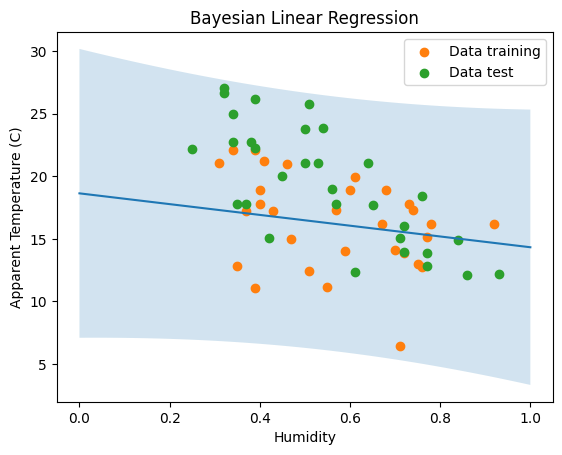

In [28]:
#FOR 1D features, we can plot the regression
xrange=np.linspace(0, 1, 100).reshape(-1,1)
plot_bayesian_LR(mN, SN, len(xrange), xrange, linear_basis, beta)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label='Data training')
plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"], label='Data test')

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Bayesian Linear Regression")
plt.legend()
plt.show()

In [29]:
from scipy.optimize import minimize
import numpy as np

def compute_marginal_log_likelihood(log_params, x, y, basis_function):
    # Converti in scala logaritmica per garantire positività
    log_alpha, log_beta = log_params
    alpha = np.exp(log_alpha)
    beta = np.exp(log_beta)

    N = len(y)
    PHI = np.hstack((np.ones((N, 1)), basis_function(x)))
    
    A = alpha * np.eye(PHI.shape[1])
    C = beta * PHI.T @ PHI + A

    try:
        sign, logdetC = np.linalg.slogdet(C)
        if sign != 1:
            return np.inf
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        return np.inf

    mN = beta * C_inv @ PHI.T @ y
    y_fit = PHI @ mN

    # log marginal likelihood
    log_likelihood = -0.5 * N * np.log(2 * np.pi) - 0.5 * logdetC \
                     - 0.5 * beta * np.sum((y - y_fit)**2)

    return -log_likelihood  # minimize => negative

res = minimize(
    compute_marginal_log_likelihood,
    x0=np.log([1e-3, 1.0]),  # initial guess in log space
    args=(x, y, linear_basis),
    method='L-BFGS-B',
    bounds=[(-10, 10), (-10, 10)]  # log(alpha), log(beta) bounds
)

# Estrai valori ottimizzati
opt_alpha, opt_beta = np.exp(res.x)
print(f"Optimal alpha: {opt_alpha}")
print(f"Optimal beta: {opt_beta}")


y_pred_bayes, sigma_pred, mN, SN = bayesian_linear_regression(x, y, linear_basis, opt_alpha, opt_beta)

Optimal alpha: 4.5399929762484854e-05
Optimal beta: 4.5399929762484854e-05


## Logistic Regression

### The problem

Given observations $(\textbf{x}_i, y_i)$ with $x_i \in \mathbb{R}^d$ and $y_i \in \{0,1\}$ we want to model $p(y | \textbf{x})$.

**Notation**

$\textbf{X}$: the dataset of input features $\textbf{x}_i$

$\textbf{Y}$: the dataset of targets $y_i$

In [30]:
import numpy as np
import os
import requests
import matplotlib.pyplot as plt


# URL of the file to download
url = 'https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/logistic_regression_data.npz'

# Send a HTTP request to the URL of the file
response = requests.get(url)

# Ensure the 'data/' directory exists
os.makedirs('data', exist_ok=True)

# Write the file
with open('data/logistic_regression_data.npz', 'wb') as f:
    f.write(response.content)

# loading the dataset
X = np.load('data/logistic_regression_data.npz')['X']
y = np.load('data/logistic_regression_data.npz')['y']


# let's split it into train and test set and normalize it
def split_and_standardize(*, X, y, ratio=0.8):
    
    # Splitting train and test sets
    cut = int(ratio * len(y))
    X_train = X[:cut]
    y_train = y[:cut]
    
    X_test = X[cut:]
    y_test = y[cut:]
    
    # Standardizing data
    x_mean = X_train.mean(axis=0)
    x_std = X_train.std(axis=0)
    
    X_train = (X_train - x_mean) / x_std
    X_test = (X_test - x_mean) / x_std
    
    return X_train, y_train, X_test, y_test


print (X.shape,len(y))

(100, 2) 100


X_test.shape: (96, 2)


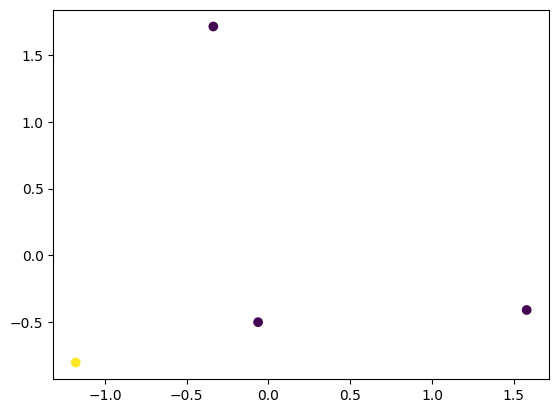

In [31]:
X_train, y_train, X_test, y_test = split_and_standardize(X=X, y=y, ratio=0.04)

_ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

print(f'X_test.shape: {X_test.shape}')

### The model

In logistic regression $p(y | \textbf{x})$ is modelled as:

$$p_{\textbf{w}}(y |  \textbf{x}) = Bernoulli(y; f(\textbf{w}^{T} \textbf{x})) $$

where $f : \mathbb{R} \rightarrow [0,1]$ is usually chosen to be the Logit $ \left( ({1 + e^{-k}})^{-1} \right)$ or the Probit.

Why $\textbf{w}^{T} \textbf{x}$ and not $\textbf{w}^{T} \textbf{x} + h$? For simplicity we prefer to avoid explicitly modelling the bias and we equivalently add a "1" as a feature to each data point. 

In [32]:
# Add the "bias feature"
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


def logit(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


def likelihood(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    p = logit(X @ w)  # (n, d) @ (d, )
    return np.where(y == 1, p, 1 - p).prod()

### Maximum likelihood fitting (frequentist)

We fit our model $p_{\textbf{w}}(y |  \textbf{x})$ by finding parameters $w$ that maximize the likelihood according to our data. For numerical reasons we equivalently maximize the log-likelihood:

$$ \log{p_{\textbf{w}}(Y |  \textbf{X})} =  \log{ \prod_i {        p_{\textbf{w}}(y_i |  \textbf{x}_i)             }} = \sum_i \log{p_{\textbf{w}}(y_i |  \textbf{x}_i)} = \sum_i \log{Bernoulli(y_i; f(\textbf{w}^{T} \textbf{x}_i))}$$

We can find $w_{ML} = \argmax_{\textbf{w}}  \log{p_{\textbf{w}}(Y |  \textbf{X})}$ using numerical optimization, in particular we can use gradient descent:

$$ w_{n+1} = w_{n} + \eta \nabla_{\textbf{w}} \log{p_{\textbf{w}}(Y |  \textbf{X})} $$

where $\eta$ is the learning rate. How do we compute the gradient? We can compute it analyticallly, but we can also use automatic differentiation with `pytorch`.

In [33]:
import torch
from tqdm.notebook import tqdm

def log_likelihood(X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    p = torch.sigmoid(X @ w)
    return torch.where(y == 1, torch.log(p + 1e-8), torch.log(1 - p + 1e-8)).sum()


def gradient_descent_optimization(loss_function, lr: float, n_iter: int, initial_guess: np.ndarray) -> np.ndarray:
    w = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    for _ in tqdm(range(n_iter)):
        loss = loss_function(w)
        loss.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad = None
    print(f"loss={ loss.item():.4g}")
    return w.cpu().detach().numpy()

In [34]:
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

loss_function = lambda w: -log_likelihood(X=X_tensor, y=y_tensor, w=w)

w_mle = gradient_descent_optimization(loss_function=loss_function, initial_guess=np.zeros(X_train.shape[1]), lr=1e-2, n_iter=5000)

print(f"MLE weights: {w_mle}")

  0%|          | 0/5000 [00:00<?, ?it/s]

loss=0.09124
MLE weights: [-4.1452184 -5.117401  -1.8846985]


In [35]:
# Veryfing the results
from sklearn.metrics import confusion_matrix

def predict(x: np.ndarray, w: np.ndarray) -> np.ndarray:
    return logit(x @ w) 

def mean_cross_entropy(y: np.ndarray, pred: np.ndarray) -> float:
    return -np.where(y, np.log(pred + 1e-8), np.log(1 - pred + 1e-8)).mean()

In [36]:
frequentist_predictions = predict(x=X_train, w=w_mle)

print(f'frequentist_predictions: {frequentist_predictions}')

print("confusion matrix: \n", confusion_matrix(y_train, frequentist_predictions > 0.5))
print(f"mean cross entropy: {mean_cross_entropy(y=y_train, pred=frequentist_predictions):.3g}")

frequentist_predictions: [5.33408979e-02 1.06089879e-05 3.50842326e-03 9.67649315e-01]
confusion matrix: 
 [[3 0]
 [0 1]]
mean cross entropy: 0.0228


### Bayesian inference

In Bayesian Inference, we want to compute the **posterior distribution**:
$$p(\textbf{w} | \mathbf{X}, Y) \propto p(Y | \textbf{w}, \mathbf{X})p(\textbf{w})$$


where $p(\textbf{w})$ is the prior, and the **predictive distribution**:
$$p(y | \mathbf{x}, \mathbf{X}, Y) = \int p(y | \mathbf{x}, \textbf{w}) p(\textbf{w} | \mathbf{X}, Y) d\textbf{w}$$

notice that $\mathbf{X}$ is always in the conditioning, we are not interested in its distribution!

#### Posterior distribution

For the posterior $p(\textbf{w} | \mathbf{X}, Y) \propto p(Y | \textbf{w}, \mathbf{X})p(\textbf{w})$ we resort to the **Laplace Approximation**:

$$p(\textbf{w} | \mathbf{X}, Y) \approx \mathcal{N}(\textbf{w}; \mu_D, \Sigma_D)$$

where $\mu_D = \textbf{w}_{MAP}$ and $\Sigma_D =  \left( - \nabla_w \nabla_w \log{p(\textbf{w}_{MAP} | Y , \mathbf{X})} \right)^{-1}$

where $\textbf{w}_{MAP} = \argmax_{\textbf{w}} \left[ p(\textbf{w} | \mathbf{X}, Y) \right]$ is the **maximum a posteriori**, equivalently $\textbf{w}_{MAP} = \argmax_{\textbf{w}}  \left[ \log{p(Y | \textbf{w}, \mathbf{X})} + \log{p(\textbf{w})} \right]$


In [37]:
# We can assume a Gaussian prior for the weights, with zero mean and a certain diagonal covariance matrix
from torch.distributions import Normal

PRIOR_STD = 100

def log_prior(w):
    return Normal(0, PRIOR_STD).log_prob(w).sum()

def log_unnormalized_posterior(X, y, w):
    return log_likelihood(X=X, y=y, w=w) + log_prior(w)

In [38]:
loss_function = lambda w: -(log_unnormalized_posterior(X=X_tensor, y=y_tensor, w=w))

w_map = gradient_descent_optimization(loss_function=loss_function, initial_guess=np.zeros(X_train.shape[1]), lr=1e-2, n_iter=5000)

print(f"MAP weights: {w_map}")

  0%|          | 0/5000 [00:00<?, ?it/s]

loss=16.67
MAP weights: [-4.1356425 -5.106282  -1.8804175]


In [39]:
def compute_hessian(f, w):
    w.requires_grad = True
    grad = torch.autograd.grad(f(w), w, create_graph=True)[0]
    hessian = torch.zeros((w.numel(), w.numel()))
    for i in range(w.numel()):
        hessian[i] = torch.autograd.grad(grad[i], w, retain_graph=True)[0]
    w.requires_grad = False
    return hessian

In [40]:
hessian = compute_hessian(f=lambda w : log_unnormalized_posterior(X=X_tensor, y=y_tensor, w=w), w=torch.tensor(w_map, dtype=torch.float32))
posterior_cov = torch.inverse(-hessian).numpy()
print("Posterior covariance matrix:\n", posterior_cov)

Posterior covariance matrix:
 [[ 28.684368  13.253782  20.48536 ]
 [ 13.253776  46.63046  -17.844378]
 [ 20.485365 -17.844372  55.998146]]


In [41]:
from scipy.special import expit  # sigmoid function

def analytical_hessian(X, w_map, prior_std):
    sigma = expit(X @ w_map)   
    r = sigma * (1 - sigma)
    R = np.diag(r) 
    hessian = (1 / prior_std**2) * np.eye(X.shape[1]) + X.T @ R @ X  
    return hessian

In [42]:
hessian = torch.tensor(analytical_hessian(X=X_train, w_map=w_map, prior_std=PRIOR_STD))
posterior_cov = torch.inverse(hessian).numpy()
print("Posterior covariance matrix:\n", posterior_cov)

Posterior covariance matrix:
 [[ 28.68437276  13.25378045  20.48536968]
 [ 13.25378045  46.63048085 -17.84437748]
 [ 20.48536968 -17.84437748  55.99815959]]


#### Predictive distribution

The approximation for the **predictive distribution** follows from the Laplace approximation of the posterior approximation (see lecture's notes for more details):
$$p(y | \mathbf{x}, \mathbf{X}, Y) \approx f\left(\kappa\left(\sigma_a^2\right) \mu_a\right)$$

where $\kappa\left(\sigma_a^2\right)=\left(1+\pi \frac{\sigma_a^2}{8}\right)^{-\frac{1}{2}}$ and $\mu_a$ and $\sigma_a^2$ are the mean and variance of the linear combination of the gaussian posterior with the observation $\mathbf{x}$.

So $\mu_a = \mathbf{\mu}_{D}^T \mathbf{x}$ and $\sigma_a^2 = \mathbf{x}^T \Sigma_{D} \mathbf{x}$

In [43]:
def laplace_predictive_distribution(*, x, posterior_mean, posterior_cov):
    mu = x @ posterior_mean # (n, d) @ (d, )
    var = np.diag(x @ posterior_cov @ x.T)
    #var = np.array([X[i] @ posterior_cov @ X[i].T for i in range(len(X))])
    k = (1 + np.pi*var/8)**(-0.5)    
    return logit(mu * k)

In [44]:
bayesian_predictions = laplace_predictive_distribution(x=X_test, posterior_mean=w_map, posterior_cov=posterior_cov)

print(f'bayesian_predictions: {bayesian_predictions}')

bayesian_predictions: [0.32815787 0.68188164 0.43740678 0.76427136 0.28345874 0.58964794
 0.73563867 0.68881434 0.22812865 0.3791301  0.36190384 0.30629043
 0.36517899 0.3742555  0.35497216 0.39003215 0.55914327 0.33764651
 0.34527003 0.20317724 0.49234503 0.187976   0.75281047 0.45135721
 0.3940173  0.21917791 0.43805914 0.57874494 0.22581667 0.2015737
 0.65374296 0.5503693  0.23640678 0.73378466 0.21982596 0.60235776
 0.18453191 0.25848804 0.2512611  0.62075041 0.70472198 0.25948552
 0.50932084 0.4682383  0.60970825 0.27010512 0.20907761 0.61044585
 0.30538058 0.44623023 0.55479664 0.41628308 0.23316503 0.7900035
 0.34919436 0.67255982 0.19485727 0.6198939  0.76945585 0.61282087
 0.64291237 0.62629317 0.62790819 0.29171021 0.18449918 0.30006491
 0.22623558 0.27986923 0.57548089 0.39557218 0.70708264 0.19110164
 0.57161214 0.30422175 0.20192158 0.64807096 0.49218272 0.31176286
 0.48922505 0.47034316 0.60516249 0.36072844 0.18937647 0.24245977
 0.58126327 0.31000193 0.29486454 0.436325

In [45]:
X = {"train": X_train, "test": X_test}
y = {"train": y_train, "test": y_test}

freq_weights = w_map

predictor = {"frequentist": lambda x : predict(x=x, w=freq_weights),
             "bayesian": lambda x :  laplace_predictive_distribution(x=x, posterior_mean=w_map, posterior_cov=posterior_cov)}

for data in ('train', 'test'):
    for model in ('frequentist', 'bayesian'):
        pred = predictor[model](X[data])
        print(f"{model} {data} mean cross entropy: {mean_cross_entropy(y=y[data], pred=pred):.2f}")
        cm = confusion_matrix(y[data], pred > 0.5) / len(y[data])
        #print(f"{model} {data} confusion matrix: \n", np.round(cm,2))
        print(f"{model} {data} accuracy: {(cm[0,0] + cm[1,1]):.1%}")
        print()

frequentist train mean cross entropy: 0.02
frequentist train accuracy: 100.0%

bayesian train mean cross entropy: 0.34
bayesian train accuracy: 100.0%

frequentist test mean cross entropy: 1.07
frequentist test accuracy: 67.7%

bayesian test mean cross entropy: 0.57
bayesian test accuracy: 67.7%



In [46]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 100

def plot_train_data(X, y):
    plt.scatter(X[y==1][:,1], X_train[y==1][:,2], c = 'red', marker='x', label='1')
    plt.scatter(X[y==0][:,1], X_train[y==0][:,2], c = 'red', marker='o', label='0')
    plt.legend()

def binary_crossentropy(*, true: np.ndarray, pred: np.ndarray):
    return -np.where(true, np.log(pred + 1e-8), np.log(1 - pred + 1e-8)).mean()

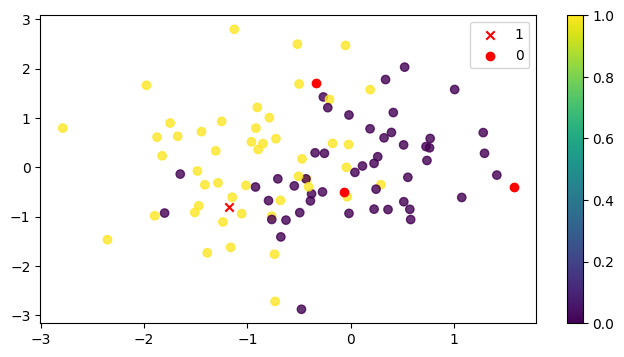

In [47]:
plt.scatter(X_test[:,1], X_test[:,2], c = y_test, alpha = 0.8)

plot_train_data(X_train, y_train)

_ = plt.colorbar()

In [48]:
pred = laplace_predictive_distribution(x=X_test, posterior_mean=w_map, posterior_cov=posterior_cov)
error = binary_crossentropy(true=y_test, pred=pred)

print(f"Test error: {error:.3f}")

Test error: 0.572


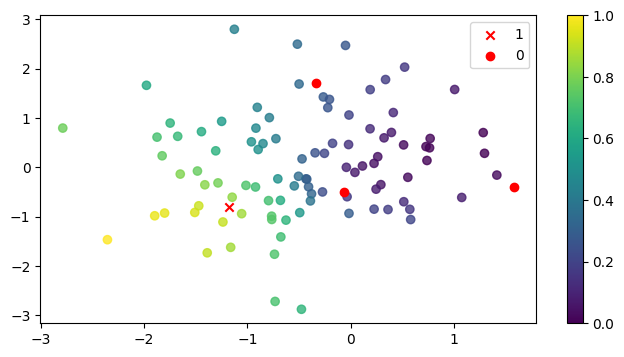

In [49]:
plt.scatter(X_test[:,1], X_test[:,2], c = pred, alpha = 0.8)

plot_train_data(X_train, y_train)

_ = plt.colorbar()

In [50]:
pred = predict(x=X_test, w=freq_weights)
error = binary_crossentropy(true=y_test, pred=pred)

print(f"Test error: {error:.3f}")

Test error: 1.074


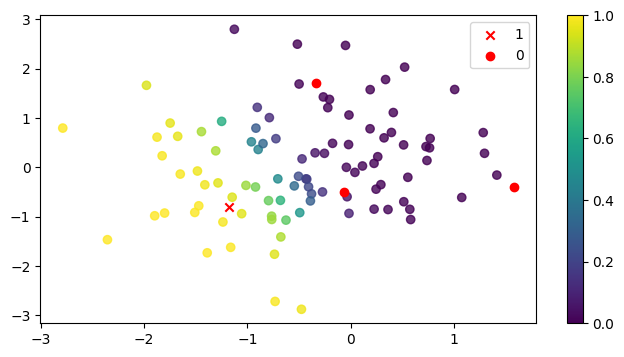

In [51]:
plt.scatter(X_test[:,1], X_test[:,2], c = pred, alpha = 0.8)

plot_train_data(X_train, y_train)

_ = plt.colorbar()

### Exercises

1. Try to repeat the analysis using more points

2. Try to repeat the analysis on the following dataset

In [52]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target 

# Creazione di un DataFrame con le feature
df = pd.DataFrame(X, columns=data.feature_names)

# Aggiunta della colonna target
df['target'] = y

# Visualizzazione delle prime righe della tabella
print(df.head(50))

print(X.shape,y.shape)


    mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.990         10.38          122.80     1001.0          0.11840   
1        20.570         17.77          132.90     1326.0          0.08474   
2        19.690         21.25          130.00     1203.0          0.10960   
3        11.420         20.38           77.58      386.1          0.14250   
4        20.290         14.34          135.10     1297.0          0.10030   
5        12.450         15.70           82.57      477.1          0.12780   
6        18.250         19.98          119.60     1040.0          0.09463   
7        13.710         20.83           90.20      577.9          0.11890   
8        13.000         21.82           87.50      519.8          0.12730   
9        12.460         24.04           83.97      475.9          0.11860   
10       16.020         23.24          102.70      797.8          0.08206   
11       15.780         17.89          103.60      781.0          0.09710   

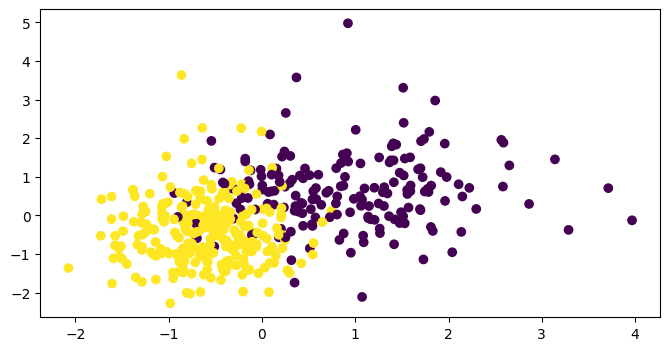

In [53]:
X_train, y_train, X_test, y_test = split_and_standardize(X=X, y=y, ratio=0.8)

_ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
